Epoch 1/5


C:\Users\jainn\anaconda3\envs\notebook\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.1689
Epoch 2/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0143
Epoch 3/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0113
Epoch 4/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0098
Epoch 5/5
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0079
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


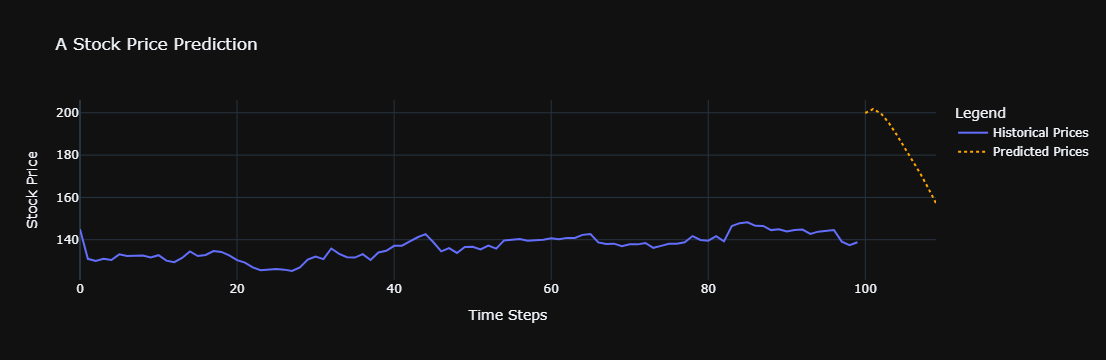

In [44]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import plotly.graph_objects as go

# Function to get the most recent stock price using yfinance
def get_real_time_stock_data(symbol):
    stock = yf.Ticker(symbol)
    data = stock.history(period="1d", interval="1m")  # Get intraday data (1-minute interval)
    if data.empty:
        raise ValueError("No real-time data available. Please check the symbol.")
    close_price = data['Close'].iloc[-1]
    return close_price

# Function to load historical stock data for training the model
def load_historical_data(symbol, data_points=500):
    stock = yf.Ticker(symbol)
    data = stock.history(period="max")  # Get maximum available historical data
    if data.empty:
        raise ValueError("No historical data available. Please check the symbol.")
    
    # Extract 'Close' prices for the last 'data_points' entries
    historical_data = data['Close'].values[-data_points:]
    
    return historical_data

# Preprocessing data for LSTM model (this part is unchanged)
def preprocess_data(data, scaler):
    data_scaled = scaler.fit_transform(data.reshape(-1, 1))
    X, y = [], []
    for i in range(60, len(data_scaled)):
        X.append(data_scaled[i-60:i, 0])
        y.append(data_scaled[i, 0])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM input
    return X, y

# Building and training the LSTM model (this part is unchanged)
def build_and_train_model(X_train, y_train):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))  # Output layer for price prediction
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.fit(X_train, y_train, epochs=5, batch_size=32)
    
    return model

# Function to predict next N stock prices using LSTM model
def predict_next_n_prices(symbol, model, scaler, last_59_prices, n=10):
    predictions = []
    
    for _ in range(n):
        new_price = get_real_time_stock_data(symbol)  # Get real-time price from yfinance
        scaled_price = scaler.transform([[new_price]])[0, 0]
        last_59_prices = np.append(last_59_prices, scaled_price)[-60:]  # Keep last 60 points
        last_60_prices = last_59_prices.reshape(1, 60, 1)
        predicted_price_scaled = model.predict(last_60_prices)
        predicted_price = scaler.inverse_transform(predicted_price_scaled)
        predictions.append(predicted_price[0][0])
        
        # Update last_59_prices for the next prediction
        last_59_prices = np.append(last_59_prices, scaled_price)[-59:]
    
    return predictions

# Function to plot historical and predicted data using Plotly
def plot_predictions(historical_data, predicted_data, symbol):
    fig = go.Figure()
    
    # Plot historical data
    fig.add_trace(go.Scatter(
        x=np.arange(len(historical_data)),
        y=historical_data,
        mode='lines',
        name='Historical Prices'
    ))
    
    # Plot predicted data
    fig.add_trace(go.Scatter(
        x=np.arange(len(historical_data), len(historical_data) + len(predicted_data)),
        y=predicted_data,
        mode='lines',
        name='Predicted Prices',
        line=dict(color='orange', dash='dot')
    ))
    
    fig.update_layout(
        title=f'{symbol} Stock Price Prediction',
        xaxis_title='Time Steps',
        yaxis_title='Stock Price',
        legend_title='Legend',
        template='plotly_dark'
    )
    
    fig.show()

# Example usage
if __name__ == '__main__':
    symbol = 'A'  # Example stock symbol
    
    # Step 1: Load historical stock prices
    historical_data = load_historical_data(symbol, data_points=500)  # Get 500 historical data points
    
    # Step 2: Preprocess data
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train, y_train = preprocess_data(historical_data, scaler)
    
    # Step 3: Build and train the LSTM model
    model = build_and_train_model(X_train, y_train)
    
    # Step 4: Predict the next 10 stock prices using real-time data
    last_59_prices = historical_data[-59:]  # Last 59 prices from historical data
    predicted_prices = predict_next_n_prices(symbol, model, scaler, last_59_prices, n=10)
    
    # Step 5: Plot the results using Plotly
    plot_predictions(historical_data[-100:], predicted_prices, symbol)  # Plot the last 100 historical points + predictions


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import plotly.graph_objects as go
from flask import Flask, jsonify, render_template, request


# Function to get the most recent stock price using yfinance
def get_real_time_stock_data(symbol):
    stock = yf.Ticker(symbol)
    data = stock.history(period="1d", interval="1m")  # Get intraday data (1-minute interval)
    if data.empty:
        raise ValueError("No real-time data available. Please check the symbol.")
    close_price = data['Close'].iloc[-1]
    return close_price

# Function to load historical stock data for training the model
def load_historical_data(symbol, data_points=500):
    stock = yf.Ticker(symbol)
    data = stock.history(period="max")  # Get maximum available historical data
    if data.empty:
        raise ValueError("No historical data available. Please check the symbol.")
    
    # Extract 'Close' prices for the last 'data_points' entries
    historical_data = data['Close'].values[-data_points:]
    
    return historical_data

# Preprocessing data for LSTM model (this part is unchanged)
def preprocess_data(data, scaler):
    data_scaled = scaler.fit_transform(data.reshape(-1, 1))
    X, y = [], []
    for i in range(60, len(data_scaled)):
        X.append(data_scaled[i-60:i, 0])
        y.append(data_scaled[i, 0])
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape for LSTM input
    return X, y

# Building and training the LSTM model (this part is unchanged)
def build_and_train_model(X_train, y_train):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))  # Output layer for price prediction
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    model.fit(X_train, y_train, epochs=5, batch_size=32)
    
    return model

# Function to predict next N stock prices using LSTM model
def predict_next_n_prices(symbol, model, scaler, last_59_prices, n=10):
    predictions = []
    
    for _ in range(n):
        new_price = get_real_time_stock_data(symbol)  # Get real-time price from yfinance
        scaled_price = scaler.transform([[new_price]])[0, 0]
        last_59_prices = np.append(last_59_prices, scaled_price)[-60:]  # Keep last 60 points
        last_60_prices = last_59_prices.reshape(1, 60, 1)
        predicted_price_scaled = model.predict(last_60_prices)
        predicted_price = scaler.inverse_transform(predicted_price_scaled)
        predictions.append(predicted_price[0][0])
        
        # Update last_59_prices for the next prediction
        last_59_prices = np.append(last_59_prices, scaled_price)[-59:]
    
    return predictions

# Function to plot historical and predicted data using Plotly
def plot_predictions(historical_data, predicted_data, symbol):
    # Create a Plotly figure
    fig = go.Figure()
    # Plot historical data
    fig.add_trace(go.Scatter(
        x=np.arange(len(historical_data)),
        y=historical_data,
        mode='lines',
        name='Historical Prices'
    ))
    # Plot predicted data
    fig.add_trace(go.Scatter(
        x=np.arange(len(historical_data), len(historical_data) + len(predicted_data)),
        y=predicted_data,
        mode='lines',
        name='Predicted Prices',
        line=dict(color='orange', dash='dot')
    ))
    fig.update_layout(
        title=f'{symbol} Stock Price Prediction',
        xaxis_title='Time Steps',
        yaxis_title='Stock Price',
        legend_title='Legend',
        template='plotly_dark'
    )
    return fig

@app.route('/')
def index():
    return render_template('index.html')  # Create an index.html file for your frontend

@app.route('/predict', methods=['POST'])
def predict():
    symbol = request.form.get('symbol')  # Get the stock symbol from the form
    historical_data = load_historical_data(symbol, data_points=500)  # Load historical data
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train, y_train = preprocess_data(historical_data, scaler)
    model = build_and_train_model(X_train, y_train)
    last_59_prices = historical_data[-59:]  # Last 59 prices
    predicted_prices = predict_next_n_prices(symbol, model, scaler, last_59_prices, n=10)
    fig = plot_predictions(historical_data[-100:], predicted_prices, symbol)
    # Return the Plotly chart as JSON
    graph_json = fig.to_json()
    return jsonify(graph_json)

if __name__ == '__main__':
    app.run(debug=True)
    
# Example usage
if __name__ == '__main__':
    symbol = 'A'  # Example stock symbol
    
    # Step 1: Load historical stock prices
    historical_data = load_historical_data(symbol, data_points=500)  # Get 500 historical data points
    
    # Step 2: Preprocess data
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train, y_train = preprocess_data(historical_data, scaler)
    
    # Step 3: Build and train the LSTM model
    model = build_and_train_model(X_train, y_train)
    
    # Step 4: Predict the next 10 stock prices using real-time data
    last_59_prices = historical_data[-59:]  # Last 59 prices from historical data
    predicted_prices = predict_next_n_prices(symbol, model, scaler, last_59_prices, n=10)
    
    # Step 5: Plot the results using Plotly
    plot_predictions(historical_data[-100:], predicted_prices, symbol)  # Plot the last 100 historical points + predictions
